In [1]:
!pip install gensim
!pip install nltk
# or use 
# pip install -U gensim 
# inside Anaconda command prompt

## Handle the Description (natural language)

In [2]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\12549\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\12549\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12549\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\12549\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\12549\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
import re
import string
import random
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser
from matplotlib import pyplot
from gensim.models import KeyedVectors
import numpy as np
import pandas as pd 

In [4]:
linkedin_data = pd.read_csv('./data/updated_wash_filtered_modified_adjusted.csv')
linkedin_data['description_x']

0        Overview\n\nHearingLife is a national hearing ...
1        Overview\n\nWho WE Are: \n\nHearingLife is a D...
2        descriptionTitle\n\n Looking for a great oppor...
3        descriptionTitle\n\n $2,000 Sign-on Bonus Guar...
4        descriptionTitle\n\nCome work as a Custodian a...
                               ...                        
13070    Great Opportunity to Gain Experience, Learn Ne...
13071    REMOTE WORK FROM HOME $1,000 TO $10,000 COMMIS...
13072    Client Success Manager (CSM)\nJob DescriptionA...
13073    Provide clerical and administrative support to...
13074    Karen Marie is looking for an awesome experien...
Name: description_x, Length: 13075, dtype: object

### Preprocessing the description

In [5]:
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)
    #print(type(s))
    #return "".join([char for char in s if char not in string.punctuation])

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join(text)
    return text


linkedin_data['description_x'] = linkedin_data['description_x'].fillna('')
linkedin_data['cleaned_description'] = linkedin_data['description_x'].apply(_removeNonAscii)
linkedin_data['cleaned_description'] = linkedin_data.cleaned_description.apply(func = make_lower_case)
linkedin_data['cleaned_description'] = linkedin_data.cleaned_description.apply(func = remove_stop_words)
linkedin_data['cleaned_description'] = linkedin_data.cleaned_description.apply(func=remove_punctuation)
linkedin_data['cleaned_description'] = linkedin_data.cleaned_description.apply(func=remove_html)
linkedin_data['cleaned_description']

0        overview hearinglife national hearing care com...
1        overview are hearinglife demant company world ...
2        descriptiontitle looking great opportunity dev...
3        descriptiontitle 2 000 sign on bonus guarantee...
4        descriptiontitle come work custodian great com...
                               ...                        
13070    great opportunity gain experience learn new sk...
13071    remote work home 1 000 10 000 commission per o...
13072    client success manager csm job descriptiona cs...
13073    provide clerical administrative support manage...
13074    karen marie looking awesome experienced stylis...
Name: cleaned_description, Length: 13075, dtype: object

### Create word of bag

In [6]:
corpus = []
for words in linkedin_data['cleaned_description']:
    corpus.append(words.split())
print(corpus[0])

['overview', 'hearinglife', 'national', 'hearing', 'care', 'company', 'part', 'demant', 'group', 'global', 'leader', 'hearing', 'healthcare', 'built', 'heritage', 'care', 'health', 'innovation', 'since', '1904', 'hearinglife', 'operates', '600', 'hearing', 'care', 'centers', 'across', '42', 'states', 'follow', 'scientific', 'results', 'oriented', 'approach', 'hearing', 'healthcare', 'provided', 'highly', 'skilled', 'caring', 'professionals', 'vision', 'help', 'people', 'hear', 'better', 'life', 'changing', 'hearing', 'health', 'delivered', 'best', 'personalized', 'care', 'team', 'member', 'must', 'uphold', 'hearinglife', 'core', 'values', 'create', 'trust', 'team', 'players', 'apply', 'can', 'do', 'attitude', 'create', 'innovative', 'solutions', 'responsibilities', 'help', 'people', 'hear', 'better', 'providing', 'clinical', 'expertise', 'diagnose', 'treat', 'hearing', 'loss', 'ensuring', 'positive', 'patient', 'experience', 'hearing', 'care', 'provider', 'acts', 'accordance', 'require

### Training the word embedding model use our word of bag

In [7]:
# word2vec model
google_model = Word2Vec(vector_size = 300, window=5, min_count = 2, workers = -1)
google_model.build_vocab(corpus)

google_model.train(corpus, total_examples=google_model.corpus_count, epochs = 5)


(0, 0)

### Turn the description to vector

In [8]:
word_embeddings = []

# Reading the each movie overview
for line in linkedin_data['cleaned_description']:
    avgword2vec = None
    count = 0
    for word in line.split():
        if word in google_model.wv.key_to_index:
            count += 1
            if avgword2vec is None:
                avgword2vec = google_model.wv[word]
            else:
                avgword2vec = avgword2vec + google_model.wv[word]
            
    if avgword2vec is not None:
        avgword2vec = avgword2vec / count
    
        word_embeddings.append(avgword2vec)
    else:
        word_embeddings.append(np.zeros(300))

word_embeddings[0]

array([ 1.34070520e-04,  1.82359319e-04, -3.58151301e-05,  1.13741589e-04,
       -1.61931493e-05,  2.04753505e-05,  9.52489718e-05,  3.01224791e-04,
        1.07120992e-04, -1.24124199e-04,  8.58805197e-06, -8.96800266e-05,
        8.08438417e-05, -3.16731603e-05, -3.28059163e-04,  8.26180167e-06,
        1.32633155e-04,  5.12813349e-05,  8.40383946e-05, -6.57990313e-05,
       -1.11095309e-04, -1.00866331e-04,  7.28492450e-05, -2.85733367e-05,
        1.47159473e-04,  5.55467814e-05, -5.89672782e-05, -1.05008607e-04,
       -1.56125592e-04, -1.31208057e-04, -9.84864309e-05,  1.35338647e-04,
       -1.54520985e-05,  1.12013462e-04, -4.10854955e-05,  1.43331563e-04,
       -1.10927813e-05, -2.33882791e-04, -1.07391781e-04,  1.42688732e-04,
       -1.24857237e-04,  3.45100299e-04, -1.16135998e-04,  9.19953600e-05,
        1.38312855e-04,  7.95935921e-05,  7.74490618e-05,  1.57916846e-04,
       -1.93954664e-04,  2.11627077e-04, -9.12002270e-06,  8.64838803e-05,
       -1.75531633e-04,  

### Merge the vector to the original dataframe

In [9]:
job_we_vector = pd.DataFrame(np.vstack(word_embeddings))
job_feature_list = job_we_vector.columns.values
job_we_vector['job_id'] = linkedin_data['job_id']
linkedin_data_with_we = pd.merge(linkedin_data, job_we_vector, on='job_id')
linkedin_data_with_we

job_id  company_id  \
0      3757940104    553718.0   
1      3757754488    553718.0   
2      3757938018  18213359.0   
3      3757936097  18213359.0   
4      3757934423  18213359.0   
...           ...         ...   
13070  1689807847  61870883.0   
13071  1657978824  89350959.0   
13072  1638550135  56186959.0   
13073   903408693   3894635.0   
13074     3958427    630152.0   

                                                   title  \
0                                  Hearing Care Provider   
1                               Patient Care Coordinator   
2                                                   Cook   
3                                             Dishwasher   
4                                      Custodian/Janitor   
...                                                  ...   
13070                        Cognitive Skills Clinician    
13071  REMOTE STEEL BUILDING SALES MAKE $1,000 TO $30...   
13072                                     Office Manager   
13073                                   Office Associate   
13074                                   Stylist/ Clorist   

                                           description_x  \
0      Overview\n\nHearingLife is a national hearing ...   
1      Overview\n\nWho WE Are: \n\nHearingLife is a D...   
2      descriptionTitle\n\n Looking for a great oppor...   
3      descriptionTitle\n\n $2,000 Sign-on Bonus Guar...   
4      descriptionTitle\n\nCome work as a Custodian a...   
...                                                  ...   
13070  Great Opportunity to Gain Experience, Learn Ne...   
13071  REMOTE WORK FROM HOME $1,000 TO $10,000 COMMIS...   
13072  Client Success Manager (CSM)\nJob DescriptionA...   
13073  Provide clerical and administrative support to...   
13074  Karen Marie is looking for an awesome experien...   

                                             skills_desc    med_salary  \
0                                                    NaN   5250.000000   
1                                                    NaN   5250.000000   
2                                                    NaN  16257.100000   
3                                                    NaN  14089.000000   
4                                                    NaN  14089.000000   
...                                                  ...           ...   
13070                                                NaN  13140.000000   
13071                                                NaN  12000.000000   
13072                                                NaN  10220.000000   
13073                                                NaN   3291.666667   
13074  Must be a seasoned stylist with an existing bo...   4791.666667   

      pay_period formatted_work_type  applies  original_listed_time  ...  \
0        MONTHLY           Full-time      NaN          1.699090e+12  ...   
1        MONTHLY           Full-time      1.0          1.699060e+12  ...   
2        MONTHLY           Full-time      NaN          1.699080e+12  ...   
3        MONTHLY           Full-time      NaN          1.699080e+12  ...   
4        MONTHLY           Full-time      NaN          1.699080e+12  ...   
...          ...                 ...      ...                   ...  ...   
13070    MONTHLY           Part-time      NaN          1.699050e+12  ...   
13071    MONTHLY            Contract      NaN          1.692830e+12  ...   
13072    MONTHLY           Part-time      NaN          1.698970e+12  ...   
13073    MONTHLY           Full-time      5.0          1.692730e+12  ...   
13074    MONTHLY           Full-time      NaN          1.699050e+12  ...   

            290       291       292       293       294       295       296  \
0      0.000057  0.000147  0.000289  0.000043 -0.000008  0.000068 -0.000030   
1      0.000155  0.000125  0.000049  0.000251  0.000009  0.000253 -0.000152   
2     -0.000066 -0.000061 -0.000038 -0.000091  0.000015 -0.000002  0.000081   
3     -0.000129 -0.000022  0.000034 -0.000059 -0.00008

## Apply the vector by company

### Find out all the company

In [10]:
linkedin_data['company_id'].count()
# Distinct company count
linkedin_data['company_id'].nunique()

5099

### Calculate the vector for every company by average

In [11]:
# Building the profile for each company

# Get all company ids
company_ids = linkedin_data['company_id'].unique()
company_ids

from sklearn.decomposition import PCA

# company_df = linkedin_data[linkedin_data['company_id'] == 18213359]
# company_df = company_df.reset_index(drop=True)
# company_description_df = pd.merge(company_df, job_we_vector, on='job_id')
# company_description_df
# company_profile_df = company_description_df.copy(deep=True)
# company_profile_df = company_profile_df[job_feature_list]
# rating_weight = [1/len(company_df)] * len(company_df)
# company_profile = company_profile_df.T.dot(rating_weight)
# X = np.array([company_profile, company_profile * 0.99])
# pca = PCA(n_components=1)
# X_pca = pca.fit_transform(X)
# print(X_pca)

# company_profile_pca = pd.DataFrame(X_pca.T, columns=['PC1', 'PC2'])
# company_profile_pca

# company_profile

# linkedin_data_with_profile = linkedin_data.copy(deep=True)

company_description_profile_df = pd.DataFrame()
# company_description_profile_df['company_id'] = company_ids

# Repeatly the same code for each company
for company_id in company_ids:
    company_df = linkedin_data[linkedin_data['company_id'] == company_id]
    company_df = company_df.reset_index(drop=True)
    company_description_df = pd.merge(company_df, job_we_vector, on='job_id')
    company_profile_df = company_description_df.copy(deep=True)
    company_profile_df = company_profile_df[job_feature_list]
    rating_weight = [1/len(company_df)] * len(company_df)
    company_profile = company_profile_df.T.dot(rating_weight)

    X = np.array([company_profile, company_profile * 0.99])
    pca = PCA(n_components=1)
    X_pca = pca.fit_transform(X)
    company_profile_pca = pd.DataFrame(X_pca.T, columns=['PCA1', 'PCA2'])
    company_profile_pca['company_id'] = company_id
    company_description_profile_df = pd.concat([company_description_profile_df, company_profile_pca], axis=0, ignore_index=True)

display(company_description_profile_df)
# linkedin_data_with_profile = pd.merge(linkedin_data_with_profile, company_profile_pca, on='company_id')
    

    # company_profile_list = company_profile.values.tolist()
    # company_profile_pca['company_id'] = company_id
    # write back to linkedin_data_with_profile to corresponding company_id
    # linkedin_data_with_profile.loc[linkedin_data_with_profile['company_id'] == company_id, job_feature_list] = company_profile[job_feature_list].values


# linkedin_data_with_profile
# company_description_profile_df


PCA1      PCA2  company_id
0    -0.000011  0.000011    553718.0
1     0.000009 -0.000009  18213359.0
2     0.000009 -0.000009    437225.0
3     0.000012 -0.000012     13727.0
4    -0.000014  0.000014  10515052.0
...        ...       ...         ...
5094 -0.000017  0.000017  61870883.0
5095 -0.000022  0.000022  89350959.0
5096  0.000015 -0.000015  56186959.0
5097 -0.000024  0.000024   3894635.0
5098 -0.000030  0.000030    630152.0

[5099 rows x 3 columns]

### Assign the vector to the dataframe by company

In [12]:

linkedin_data_with_profile = linkedin_data.copy(deep=True)
# linkedin_data_with_profile
linkedin_data_with_profile = pd.merge(linkedin_data_with_profile, company_description_profile_df, on='company_id')
linkedin_data_with_profile.drop(['description_x', 'cleaned_description'], axis=1, inplace=True)
linkedin_data_with_profile

job_id  company_id  \
0      3757940104    553718.0   
1      3757754488    553718.0   
2      3757938018  18213359.0   
3      3757936097  18213359.0   
4      3757934423  18213359.0   
...           ...         ...   
13070  1689807847  61870883.0   
13071  1657978824  89350959.0   
13072  1638550135  56186959.0   
13073   903408693   3894635.0   
13074     3958427    630152.0   

                                                   title  \
0                                  Hearing Care Provider   
1                               Patient Care Coordinator   
2                                                   Cook   
3                                             Dishwasher   
4                                      Custodian/Janitor   
...                                                  ...   
13070                        Cognitive Skills Clinician    
13071  REMOTE STEEL BUILDING SALES MAKE $1,000 TO $30...   
13072                                     Office Manager   
13073                                   Office Associate   
13074                                   Stylist/ Clorist   

                                             skills_desc    med_salary  \
0                                                    NaN   5250.000000   
1                                                    NaN   5250.000000   
2                                                    NaN  16257.100000   
3                                                    NaN  14089.000000   
4                                                    NaN  14089.000000   
...                                                  ...           ...   
13070                                                NaN  13140.000000   
13071                                                NaN  12000.000000   
13072                                                NaN  10220.000000   
13073                                                NaN   3291.666667   
13074  Must be a seasoned stylist with an existing bo...   4791.666667   

      pay_period formatted_work_type  applies  original_listed_time  \
0        MONTHLY           Full-time      NaN          1.699090e+12   
1        MONTHLY           Full-time      1.0          1.699060e+12   
2        MONTHLY           Full-time      NaN          1.699080e+12   
3        MONTHLY           Full-time      NaN          1.699080e+12   
4        MONTHLY           Full-time      NaN          1.699080e+12   
...          ...                 ...      ...                   ...   
13070    MONTHLY           Part-time      NaN          1.699050e+12   
13071    MONTHLY            Contract      NaN          1.692830e+12   
13072    MONTHLY           Part-time      NaN          1.698970e+12   
13073    MONTHLY           Full-time      5.0          1.692730e+12   
13074    MONTHLY           Full-time      NaN          1.699050e+12   

       remote_allowed  ...  sponsored currency compensation_type     scraped  \
0                 NaN  ...          0      USD       BASE_SALARY  1699138101   
1                 NaN  ...          0      USD       BASE_SALARY  1699131481   
2                 NaN  ...          0      USD       BASE_SALARY  1699087461   
3                 NaN  ...          0      USD       BASE_SALARY  1699089324   
4                 NaN  ...          0      USD       BASE_SALARY  1699132006   
...               ...  ...        ...      ...               ...         ...   
13070             NaN  ...          0      USD       BASE_SALARY  1699062459   
13071             1.0  ...          0      USD       BASE_SALARY  1698994658   
13072             NaN  ...          0      USD       BASE_SALARY  1698993921   
13073             NaN  ...          1      USD       BASE_SALARY  1698994658   
13074             NaN  ...          0      USD       BASE_SALARY  1699057868   

       company_size       state country      city      PCA1      PCA2  
0               5.0  New Jersey      US  Somerset -0.000011  0.000011  
1               5.0  New Jersey      US  Somer

## Feature Engineering

### Feature selection by deleting the attributes that apparently not correlate to the output, and assign default value to the Nan values

In [13]:
linkedin_data_with_profile_selected = linkedin_data_with_profile.copy(deep=True)
linkedin_data_with_profile_selected = linkedin_data_with_profile_selected.drop(['job_id', 'company_id', 'title', 'skills_desc', 'pay_period', 'currency', 'compensation_type', 'scraped', 'state', 'city'], axis=1, inplace=False)

linkedin_data_with_profile_selected['remote_allowed'].fillna(0, inplace=True)
linkedin_data_with_profile_selected['applies'].fillna(0, inplace=True)
linkedin_data_with_profile_selected['views'].fillna(0, inplace=True)
linkedin_data_with_profile_selected['company_size'].fillna(0, inplace=True)
linkedin_data_with_profile_selected.drop(linkedin_data_with_profile_selected[linkedin_data_with_profile_selected.company_size == 0].index, inplace=True)
linkedin_data_with_profile_selected['formatted_experience_level'].fillna('Not_Specified', inplace=True)

# lin_data_pro_selected = linkedin_data_with_profile_selected.copy(deep=True)

# display(lin_data_pro_selected)

# linkedin_data_with_profile_selected['PCA2'].max()


### From Here we have two parts: one part for conversion rate, and another part is for views

#### 1. Conversion rate part: We firstly eleminate the job that the views number less than 5, then using applies/views to find out the conversion rate

In [14]:
# Researching the conversion rate
linkedin_conversion = linkedin_data_with_profile_selected.copy(deep=True)
linkedin_conversion.drop(linkedin_conversion[linkedin_conversion.views <= 5].index, inplace=True)
linkedin_conversion.drop(linkedin_conversion[linkedin_conversion.applies > linkedin_conversion.views].index, inplace=True)
linkedin_conversion['conversion_rate'] = linkedin_conversion['applies'] / linkedin_conversion['views']


display(linkedin_conversion)

# linkedin_conversion_high_conversion = linkedin_conversion[linkedin_conversion.conversion_rate]
# linkedin_conversion_high_conversion.to_csv('./data/linkedin_conversion_high_conversion.csv', index=False)


med_salary formatted_work_type  applies  original_listed_time  \
0       5250.000000           Full-time      0.0          1.699090e+12   
20     10000.000000           Full-time      0.0          1.699060e+12   
27      5083.333333           Full-time      0.0          1.698960e+12   
28      6041.666667           Full-time      0.0          1.696930e+12   
29     10220.000000           Part-time      2.0          1.692820e+12   
...             ...                 ...      ...                   ...   
13061  23783.400000           Full-time      1.0          1.692740e+12   
13062   3541.666667           Full-time      3.0          1.692730e+12   
13065   6041.666667           Full-time     10.0          1.699050e+12   
13067  16425.000000           Full-time      0.0          1.692740e+12   
13073   3291.666667           Full-time      5.0          1.692730e+12   

       remote_allowed  views    application_type formatted_experience_level  \
0                 0.0    9.0        OffsiteApply                Entry level   
20                0.0    9.0        OffsiteApply           Mid-Senior level   
27                1.0  130.0        OffsiteApply                Entry level   
28                1.0   57.0        OffsiteApply           Mid-Senior level   
29                1.0   21.0        OffsiteApply              Not_Specified   
...               ...    ...                 ...                        ...   
13061             0.0   19.0  ComplexOnsiteApply              Not_Specified   
13062             0.0   17.0  ComplexOnsiteApply              Not_Specified   
13065             0.0   71.0  ComplexOnsiteApply              Not_Specified   
13067             0.0   17.0  ComplexOnsiteApply              Not_Specified   
13073             0.0   49.0  ComplexOnsiteApply              Not_Specified   

        listed_time  sponsored  company_size country      PCA1      PCA2  \
0      1.699090e+12          0           5.0      US -0.000011  0.000011   
20     1.699060e+12          0           5.0      US  0.000012 -0.000012   
27     1.699090e+12          0           4.0      US -0.000011  0.000011   
28     1.699090e+12          0           4.0      US -0.000011  0.000011   
29     1.692820e+12          0           4.0      US -0.000015  0.000015   
...             ...        ...           ...     ...       ...       ...   
13061  1.692740e+12          0           1.0      US  0.000016 -0.000016   
13062  1.692730e+12          0           1.0      US  0.000013 -0.000013   
13065  1.699050e+12          1           1.0      US -0.000010  0.000010   
13067  1.692740e+12          1           1.0      US -0.000017  0.000017   
13073  1.692730e+12          1           2.0      US -0.000024  0.000024   

       conversion_rate  
0             0.000000  
20            0.000000  
27            0.000000  
28            0.000000  
29            0.095238  
...                ...  
13061         0.052632  
13062         0.176471  
13065         0.140845  
13067         0.000000  
13073         0.102041  

[7313 rows x 15 columns]

#### Import the necessary package

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
print(linkedin_conversion.columns)
linkedin_conversion_no_time = linkedin_conversion.drop(['original_listed_time', 'listed_time'], axis=1, inplace=False)
linkedin_conversion_no_time

Index(['med_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'views', 'application_type',
       'formatted_experience_level', 'listed_time', 'sponsored',
       'company_size', 'country', 'PCA1', 'PCA2', 'conversion_rate'],
      dtype='object')


med_salary formatted_work_type  applies  remote_allowed  views  \
0       5250.000000           Full-time      0.0             0.0    9.0   
20     10000.000000           Full-time      0.0             0.0    9.0   
27      5083.333333           Full-time      0.0             1.0  130.0   
28      6041.666667           Full-time      0.0             1.0   57.0   
29     10220.000000           Part-time      2.0             1.0   21.0   
...             ...                 ...      ...             ...    ...   
13061  23783.400000           Full-time      1.0             0.0   19.0   
13062   3541.666667           Full-time      3.0             0.0   17.0   
13065   6041.666667           Full-time     10.0             0.0   71.0   
13067  16425.000000           Full-time      0.0             0.0   17.0   
13073   3291.666667           Full-time      5.0             0.0   49.0   

         application_type formatted_experience_level  sponsored  company_size  \
0            OffsiteApply                Entry level          0           5.0   
20           OffsiteApply           Mid-Senior level          0           5.0   
27           OffsiteApply                Entry level          0           4.0   
28           OffsiteApply           Mid-Senior level          0           4.0   
29           OffsiteApply              Not_Specified          0           4.0   
...                   ...                        ...        ...           ...   
13061  ComplexOnsiteApply              Not_Specified          0           1.0   
13062  ComplexOnsiteApply              Not_Specified          0           1.0   
13065  ComplexOnsiteApply              Not_Specified          1           1.0   
13067  ComplexOnsiteApply              Not_Specified          1           1.0   
13073  ComplexOnsiteApply              Not_Specified          1           2.0   

      country      PCA1      PCA2  conversion_rate  
0          US -0.000011  0.000011         0.000000  
20         US  0.000012 -0.000012         0.000000  
27         US -0.000011  0.000011         0.000000  
28         US -0.000011  0.000011         0.000000  
29         US -0.000015  0.000015         0.095238  
...       ...       ...       ...              ...  
13061      US  0.000016 -0.000016         0.052632  
13062      US  0.000013 -0.000013         0.176471  
13065      US -0.000010  0.000010         0.140845  
13067      US -0.000017  0.000017         0.000000  
13073      US -0.000024  0.000024         0.102041  

[7313 rows x 13 columns]

e:\acd\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='conversion_rate', ylabel='Count'>

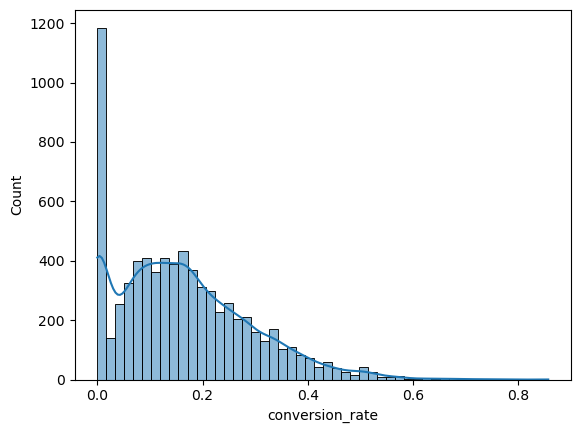

In [17]:
# show the conversion_rate distribution

sns.histplot(linkedin_conversion_no_time['conversion_rate'], bins=50, kde=True)

In [18]:
linkedin_conversion_no_time[linkedin_conversion_no_time['conversion_rate'] >= 1].count()

display(linkedin_conversion_no_time[linkedin_conversion_no_time.conversion_rate >= 1])

Empty DataFrame
Columns: [med_salary, formatted_work_type, applies, remote_allowed, views, application_type, formatted_experience_level, sponsored, company_size, country, PCA1, PCA2, conversion_rate]
Index: []

#### Using t = 0.5 as the thereshold to identify whether a job is popular or not, and assign the True or False to the 'popular' attribute

In [19]:
linkedin_conversion_no_time_absolute = linkedin_conversion_no_time.copy(deep=True)
linkedin_conversion_no_time_absolute['popular'] = linkedin_conversion_no_time_absolute['conversion_rate'].apply(lambda x: 'True' if x >= 0.5 else 'False')
# linkedin_conversion_no_time_absolute.to_csv('./data/linkedin_conversion_no_time_absolute.csv', index=False)

#### Using random forest to identify the importance of the attributes

In [20]:
targets = ['med_salary', 'formatted_work_type', 'applies',
       'remote_allowed', 'application_type',
       'formatted_experience_level', 'sponsored',
       'company_size', 'country', 'PCA1', 'PCA2']

column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

# Create a random forest classifier for feature importance
clf = RandomForestClassifier(n_jobs=6, class_weight='balanced')

reg = LinearRegression()

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(linkedin_conversion_no_time_absolute[targets], 
                                   linkedin_conversion_no_time_absolute['popular'], test_size=0.3, random_state=0)

pipeline.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002854A9460E0>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002854A946020>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6))])

In [21]:
pipeline['clf'].feature_importances_

array([0.13774068, 0.35648885, 0.02029251, 0.02814648, 0.07738891,
       0.1122501 , 0.11998415, 0.01849503, 0.06417542, 0.05347162,
       0.01156624])

#### Feature importance result, the higher, the more important
However, the importance is not as the same as the weight of the attributes, same as the followings. If we want to know the further accurate weight, we need to do other trainings.

In [22]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).\
                      sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 1.0


FEATURE  IMPORTANCE    CUMSUM
1          formatted_work_type    0.356489  0.356489
0                   med_salary    0.137741  0.494230
6                    sponsored    0.119984  0.614214
5   formatted_experience_level    0.112250  0.726464
4             application_type    0.077389  0.803853
8                      country    0.064175  0.868028
9                         PCA1    0.053472  0.921500
3               remote_allowed    0.028146  0.949646
2                      applies    0.020293  0.969939
7                 company_size    0.018495  0.988434
10                        PCA2    0.011566  1.000000

In [23]:
print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))

Most Important Features:
['med_salary', 'formatted_work_type', 'application_type', 'formatted_experience_level', 'sponsored', 'country', 'PCA1']
Number of Included Features = 7


#### 2. Views part
Quite same as the conversion part

Drop the irrelevant attributes

In [24]:
# Researching the views
linkedin_views = linkedin_data_with_profile_selected.copy(deep=True)
linkedin_views.drop('applies', axis=1, inplace=True)
display(linkedin_views)

med_salary formatted_work_type  original_listed_time  remote_allowed  \
0       5250.000000           Full-time          1.699090e+12             0.0   
1       5250.000000           Full-time          1.699060e+12             0.0   
2      16257.100000           Full-time          1.699080e+12             0.0   
3      14089.000000           Full-time          1.699080e+12             0.0   
4      14089.000000           Full-time          1.699080e+12             0.0   
...             ...                 ...                   ...             ...   
13069   8688.387500           Full-time          1.692860e+12             0.0   
13070  13140.000000           Part-time          1.699050e+12             0.0   
13071  12000.000000            Contract          1.692830e+12             1.0   
13072  10220.000000           Part-time          1.698970e+12             0.0   
13073   3291.666667           Full-time          1.692730e+12             0.0   

       views    application_type formatted_experience_level   listed_time  \
0        9.0        OffsiteApply                Entry level  1.699090e+12   
1        2.0        OffsiteApply                Entry level  1.699060e+12   
2        1.0        OffsiteApply                Entry level  1.699080e+12   
3        0.0        OffsiteApply                Entry level  1.699080e+12   
4        0.0        OffsiteApply                Entry level  1.699110e+12   
...      ...                 ...                        ...           ...   
13069    0.0        OffsiteApply           Mid-Senior level  1.692860e+12   
13070    0.0   SimpleOnsiteApply              Not_Specified  1.699050e+12   
13071    0.0        OffsiteApply              Not_Specified  1.692830e+12   
13072    2.0  ComplexOnsiteApply              Not_Specified  1.698970e+12   
13073   49.0  ComplexOnsiteApply              Not_Specified  1.692730e+12   

       sponsored  company_size country      PCA1      PCA2  
0              0           5.0      US -0.000011  0.000011  
1              0           5.0      US -0.000011  0.000011  
2              0           4.0      US  0.000009 -0.000009  
3              0           4.0      US  0.000009 -0.000009  
4              0           4.0      US  0.000009 -0.000009  
...          ...           ...     ...       ...       ...  
13069          0           3.0      US -0.000013  0.000013  
13070          0           1.0      US -0.000017  0.000017  
13071          0           2.0       0 -0.000022  0.000022  
13072          0           2.0      US  0.000015 -0.000015  
13073          1           2.0      US -0.000024  0.000024  

[12409 rows x 13 columns]

In [25]:
linkedin_views_no_time = linkedin_views.copy(deep=True)
linkedin_views_no_time.drop(['original_listed_time', 'listed_time'], axis=1, inplace=True)
linkedin_views_no_time

med_salary formatted_work_type  remote_allowed  views  \
0       5250.000000           Full-time             0.0    9.0   
1       5250.000000           Full-time             0.0    2.0   
2      16257.100000           Full-time             0.0    1.0   
3      14089.000000           Full-time             0.0    0.0   
4      14089.000000           Full-time             0.0    0.0   
...             ...                 ...             ...    ...   
13069   8688.387500           Full-time             0.0    0.0   
13070  13140.000000           Part-time             0.0    0.0   
13071  12000.000000            Contract             1.0    0.0   
13072  10220.000000           Part-time             0.0    2.0   
13073   3291.666667           Full-time             0.0   49.0   

         application_type formatted_experience_level  sponsored  company_size  \
0            OffsiteApply                Entry level          0           5.0   
1            OffsiteApply                Entry level          0           5.0   
2            OffsiteApply                Entry level          0           4.0   
3            OffsiteApply                Entry level          0           4.0   
4            OffsiteApply                Entry level          0           4.0   
...                   ...                        ...        ...           ...   
13069        OffsiteApply           Mid-Senior level          0           3.0   
13070   SimpleOnsiteApply              Not_Specified          0           1.0   
13071        OffsiteApply              Not_Specified          0           2.0   
13072  ComplexOnsiteApply              Not_Specified          0           2.0   
13073  ComplexOnsiteApply              Not_Specified          1           2.0   

      country      PCA1      PCA2  
0          US -0.000011  0.000011  
1          US -0.000011  0.000011  
2          US  0.000009 -0.000009  
3          US  0.000009 -0.000009  
4          US  0.000009 -0.000009  
...       ...       ...       ...  
13069      US -0.000013  0.000013  
13070      US -0.000017  0.000017  
13071       0 -0.000022  0.000022  
13072      US  0.000015 -0.000015  
13073      US -0.000024  0.000024  

[12409 rows x 11 columns]

In [26]:

print(linkedin_views_no_time.columns)

Index(['med_salary', 'formatted_work_type', 'remote_allowed', 'views',
       'application_type', 'formatted_experience_level', 'sponsored',
       'company_size', 'country', 'PCA1', 'PCA2'],
      dtype='object')


#### Using random forest to identify the importance of one attribute

In [27]:
targets = ['med_salary', 'formatted_work_type', 'remote_allowed',
       'application_type', 'formatted_experience_level', 'sponsored',
       'company_size', 'country', 'PCA1', 'PCA2']

column_trans = ColumnTransformer(transformers=
        [('num', MinMaxScaler(), selector(dtype_exclude="object")),
        ('cat', OrdinalEncoder(), selector(dtype_include="object"))],
        remainder='drop')

# Create a random forest classifier for feature importance
clf = RandomForestClassifier(n_jobs=6, class_weight='balanced')

reg = LinearRegression()

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

# Split the data into 30% test and 70% training
X_train, X_test, y_train, y_test = train_test_split(linkedin_views_no_time[targets], 
                                   linkedin_views_no_time['views'], test_size=0.3, random_state=0)

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002854A983880>),
                                                 ('cat', OrdinalEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000002854A9828F0>)])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=6))])

#### List out the important features for views

In [28]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats = []
# Print the name and gini importance of each feature
for feature in zip(targets, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats.append(feature[0])

print('\n',"Cumulative Importance =", total_importance)

# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).\
                      sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
df_imp


 Cumulative Importance = 1.0


FEATURE  IMPORTANCE    CUMSUM
0                  med_salary    0.265105  0.265105
4  formatted_experience_level    0.218008  0.483113
5                   sponsored    0.215030  0.698142
3            application_type    0.083824  0.781966
8                        PCA1    0.068933  0.850900
2              remote_allowed    0.037575  0.888475
7                     country    0.036067  0.924542
9                        PCA2    0.025659  0.950200
6                company_size    0.025571  0.975771
1         formatted_work_type    0.024229  1.000000

#### Important Feature for view

In [29]:
print('Most Important Features:')
print(included_feats)
print('Number of Included Features =', len(included_feats))
columns_to_remove=['remote_allowed','country','PCA2',"formatted_work_type"]

Most Important Features:
['med_salary', 'application_type', 'formatted_experience_level', 'sponsored', 'PCA1']
Number of Included Features = 5
